## Contents

- [Data Import and Checks](#Data-Import-and-Checks)
- [Modelling](#Modelling)
- [Model Improvement](#Model-Improvement-by-Stacking)
- [Evaluation](#Evaluation)
- [Conclusion](#Conclusion)

## Libraries

In [1]:
# Import libaries
import pandas as pd
import regex as re
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
import time

from sklearn import metrics
import scikitplot as skplt
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier

from lightgbm import LGBMClassifier
from pycaret.classification import *

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Import and Checks

In [3]:
combi_df = pd.read_csv('../datasets/combined_clean.csv')

In [4]:
print(combi_df.shape)
combi_df.head()

(45582, 2)


,clean_text,subreddit
0,new studi explor peopl drop t enrol,science
1,dog discrimin human baselin psycholog stress c...,science
2,new look extrem rare femal infant burial europ...,science
3,concuss associ 60 increas suicid attempt high ...,science
4,citi warm urban greeneri help studi,science


In [5]:
#double checking for missing values
print(combi_df.isnull().sum())
combi_df[combi_df.isnull().any(axis=1)].head()

clean_text    1294
subreddit        0
dtype: int64


,clean_text,subreddit
591,NaN,science
1204,NaN,science
2210,NaN,science
2284,NaN,science
2350,NaN,science


In [6]:
#dropping rows with missing values
combi_df.dropna(inplace=True)

In [7]:
#reset index
combi_df.reset_index(drop=True)

,clean_text,subreddit
0,new studi explor peopl drop t enrol,science
1,dog discrimin human baselin psycholog stress c...,science
2,new look extrem rare femal infant burial europ...,science
3,concuss associ 60 increas suicid attempt high ...,science
4,citi warm urban greeneri help studi,science
...,...,...
44283,friedrich nietzsch s metamorphos spirit explain,philosophy
44284,overview friedrich nietzsch s idea metamorphos,philosophy
44285,worst enemi step away best friend,philosophy
44286,expect ignit psycholog molotov cocktail,philosophy


In [8]:
# Change subreddit to 1 for philosophy and 0 for science
combi_df['subreddit'] = combi_df['subreddit'].map({'philosophy': 1, 'science': 0})

------------------------------------------------

## Modelling

In [9]:
X=combi_df['clean_text']
y=combi_df['subreddit']

In [10]:
#split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25,
                              random_state=42, stratify=y)

In [11]:
#checking accuracy of baseline mode
y.value_counts(normalize=True)

0    0.53134
1    0.46866
Name: subreddit, dtype: float64

### Baseline Model
For our baseline model, we will be using [MultinominalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) which is suitable for classification with discrete features (e.g., word counts for text classification), with `CountVectorizer`. 
Naive Bayes assumes that all predictors (or features) are independent, which rarely happens in real life [(source)](https://www.kaggle.com/getting-started/225022). Therefore, it will be a good baseline model to use. We will also hypertune its parameters of the vectorizer.

In [20]:
#using countvectorizer with Multinomial Naive Bayes
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters
nb_params = {
    'cvec__max_features': [2000, 3000], 
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)] 
} 

# Instantiate GridSearchCV.
gs_nb = GridSearchCV(pipe_nb, param_grid=nb_params, cv=5, n_jobs = -1, verbose=1)

In [21]:
# Fit GridSearch to training data.
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [22]:
#checking for best parameters
print(gs_nb.best_params_)
print(gs_nb.best_score_)

{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}


In [109]:
y_preds_nb = gs_nb.predict(X_test)

In [110]:
#checking scores
print(f'Train Accuracy Score: {gs_nb.score(X_train, y_train)}')
print(f'Test Accuracy Score: {metrics.accuracy_score(y_test, y_preds_nb)}')
print(f'F1: {metrics.f1_score(y_test, y_preds_nb)}')
print(f'Precision: {metrics.precision_score(y_test, y_preds_nb)}')
print(f'Recall: {metrics.recall_score(y_test, y_preds_nb)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test, y_preds_nb)}')

Train Accuracy Score: 0.8858983622350675
Test Accuracy Score: 0.8758128612716763
F1: 0.8647319232661093
Precision: 0.8832395498392283
Recall: 0.8469840046251687
ROC_AUC: 0.8741124340650914


From the results, `Multinomial NB` with default parameters with `CountVectorizer` (tuned parameters) has given a decent score of 0.89 for train dataset and 0.88 for test dataset. Though a high benchmark to go against, there may be other models that will outperform this model after hyperparameter tuning as well in both the vectorizer and the estimator.

### RandomForest

[RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. This greatly reduces the variance of the model, at the expense of a small increase in bias, making in generally superior to full-sized bagging. Here, we will be looking at `Random Forest Classifier` as an additional model to compare to, in order to help choose the final model for the project.

In [25]:
# Random Forest
#using countvectorizer with Multinomial Naive Bayes
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()), 
    ('rf', RandomForestClassifier())
])

rf_params = {
    'cvec__max_features': [2000, 3000], 
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.5, .75],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [5, 6],
    'rf__criterion': ['gini'],
    'rf__min_samples_split': [5, 15],
}

# Instantiate GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid=rf_params, cv=5,n_jobs = -1,verbose = 1)

In [26]:
# Fit GridSearch to training data.
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.5, 0.75],
                         'cvec__max_features': [2000, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__criterion': ['gini'], 'rf__max_depth': [5, 6],
                         'rf__min_samples_split': [5, 15],
                         'rf__n_estimators': [100, 150]},
             verbose=1)

In [106]:
#checking for best parameters
print(gs_rf.best_params_)
print(gs_rf.best_score_)

{'cvec__max_df': 0.75, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__min_samples_split': 15, 'rf__n_estimators': 150}
0.8434189959546032


In [107]:
y_preds_rf = gs_rf.predict(X_test)

In [108]:
#checking scores
print(f'Train Accuracy Score: {gs_rf.score(X_train, y_train)}')
print(f'Test Accuracy Score: {metrics.accuracy_score(y_test, y_preds_rf)}')
print(f'F1: {metrics.f1_score(y_test, y_preds_rf)}')
print(f'Precision: {metrics.precision_score(y_test, y_preds_rf)}')
print(f'Recall: {metrics.recall_score(y_test, y_preds_rf)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test, y_preds_rf)}')

Train Accuracy Score: 0.7134212427745664
Test Accuracy Score: 0.7036669075144508
F1: 0.5568012967715791
Precision: 0.9308943089430894
Recall: 0.39718635575255345
ROC_AUC: 0.6855896082689337


As compared to `Multinomial NB` on default parameters, with hyperparameter-tuned `CountVectorizer`, it did not perform as well with a train score of 0.71 and test score of 0.70. This is probably due to its sensitivity to sample size as too large of sample size might incur larger number of trees are involved and thus, more calculations. The precision score of 0.931 is much better than the recall score of 0.397 which shows it's strength is in minimizing predicting false positives.

### Choosing the Best Model Using Pycaret

Instead of creating different models one by one, we will be using [Pycaret](https://pycaret.gitbook.io/docs/) which is essentially a wrapper around several machine learning libraries and frameworks, such as in scikit-learn. This machine learning library will help generate different classifier models (in this case) and allows us to compare the scores in a table format for easier reference and evaluation.

Firstly, we will differentiate between which word vectorizer will be more suitable for the final model. `CountVectorizer`and `TFIDF Vectorizer` were used in separate Pycaret modelling. Then, we will compare the scores in each Pycaret generation, choose which combination will have the best scoring metrics and pick that as the best model.

Pycaret will generate the models and give the scores based on 7 scoring metrics, however we will generally only be looking at the below metrics (as defined):
- Accuracy Score: Accuracy of classification model on the train dataset
- AUC Score: Area Under Curve where its the probability that a random True Positive is found in True Negative.
- Recall: True Positive Rate (True Positives / Total Actual Positives)
- Precision: Positive Predictive Value (True Positives / Total Positive Predictions)
- F1: Weighted average of precision and recall


#### CountVectorizer

In [30]:
# BoW-CVec Embedding
cvec_vectorizer = CountVectorizer(min_df=.02, max_df=.8, ngram_range=[1,3])

%time tpl_cvec = cvec_vectorizer.fit_transform(X_train)
display("Bow-CVec: :", tpl_cvec.shape)
df_cvec = pd.DataFrame(tpl_cvec.toarray(), columns=cvec_vectorizer.get_feature_names(), index=X_train.index)
df_cvec.head()

CPU times: user 1.6 s, sys: 104 ms, total: 1.71 s
Wall time: 1.78 s


'Bow-CVec: :'

(33216, 28)

,19,2022,associ,brain,cell,chang,covid,covid 19,develop,effect,free,health,help,human,increas,life,make,new,new studi,peopl,philosoph,research,risk,scientist,studi,time,world,year
44524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11088,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
#Preparing processed and BoW-CVec embedded data for Classification
df_cvec_m = pd.concat([df_cvec,y_train], axis = 1)
print(df_cvec_m.shape)
df_cvec_m.head()

(33216, 29)


,19,2022,associ,brain,cell,chang,covid,covid 19,develop,effect,free,health,help,human,increas,life,make,new,new studi,peopl,philosoph,research,risk,scientist,studi,time,world,year,subreddit
44524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11088,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [32]:
df_cvec_m_columns = df_cvec_m.columns
df_cvec_m_columns

Index(['19', '2022', 'associ', 'brain', 'cell', 'chang', 'covid', 'covid 19',
       'develop', 'effect', 'free', 'health', 'help', 'human', 'increas',
       'life', 'make', 'new', 'new studi', 'peopl', 'philosoph', 'research',
       'risk', 'scientist', 'studi', 'time', 'world', 'year', 'subreddit'],
      dtype='object')

In [33]:
#ensuring no numerical strings in columns, eg 2022 and 19
res = [sub for sub in df_cvec_m_columns if sub.isalpha()]

In [34]:
#dropping numerical strings
df_cvec_m = df_cvec_m.drop(columns=[col for col in df_cvec_m if col not in res])
df_cvec_m.head()

,associ,brain,cell,chang,covid,develop,effect,free,health,help,human,increas,life,make,new,peopl,philosoph,research,risk,scientist,studi,time,world,year,subreddit
44524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11088,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [35]:
#making a list to categorize the features as 'Categorical' in Pycaret. If not, Pycaret may treat it as just a numerical feature
cat_list = df_cvec_m.columns.values.tolist()

In [36]:
#remove subreddit from list as it is not a categorical feature
cat_list.remove('subreddit')

In [37]:
pce_2 = setup(data = df_cvec_m, target = 'subreddit', session_id = 5, categorical_features=cat_list)

,Description,Value
0,session_id,5
1,Target,subreddit
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(33216, 25)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,24
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
%time compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7413,0.7899,0.9416,0.6565,0.7736,0.4935,0.5383,0.1340
xgboost,Extreme Gradient Boosting,0.7412,0.7912,0.9411,0.6564,0.7733,0.4931,0.5378,4.1040
gbc,Gradient Boosting Classifier,0.7410,0.7876,0.9460,0.6552,0.7742,0.4932,0.5401,0.8600
et,Extra Trees Classifier,0.7408,0.7877,0.9403,0.6562,0.7730,0.4924,0.5369,0.7290
lr,Logistic Regression,0.7407,0.7903,0.9411,0.6560,0.7731,0.4923,0.5371,0.8890
ada,Ada Boost Classifier,0.7406,0.7894,0.9414,0.6557,0.7730,0.4920,0.5370,0.2970
rf,Random Forest Classifier,0.7404,0.7886,0.9412,0.6556,0.7728,0.4916,0.5366,0.7570
dt,Decision Tree Classifier,0.7401,0.7860,0.9400,0.6556,0.7724,0.4911,0.5356,0.0650
svm,SVM - Linear Kernel,0.7397,0.0000,0.9419,0.6548,0.7725,0.4903,0.5358,0.1830
ridge,Ridge Classifier,0.7383,0.0000,0.9416,0.6535,0.7715,0.4877,0.5335,0.0370


CPU times: user 6.8 s, sys: 448 ms, total: 7.25 s
Wall time: 2min 14s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### TF:IDF Vectorization

In [39]:
# BoW-TF:IDF Embedding
tfidf_vectorizer = TfidfVectorizer(min_df=.02, max_df=.8, ngram_range=[1,3])

%time tpl_tfidf = tfidf_vectorizer.fit_transform(X_train)
display("Bow-TF:IDF :", tpl_tfidf.shape)
df_tfidf = pd.DataFrame(tpl_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names(), index=X_train.index)
df_tfidf.head()


CPU times: user 1.5 s, sys: 78.1 ms, total: 1.58 s
Wall time: 1.6 s


'Bow-TF:IDF :'

(33216, 28)

,19,2022,associ,brain,cell,chang,covid,covid 19,develop,effect,...,new studi,peopl,philosoph,research,risk,scientist,studi,time,world,year
44524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#Preparing processed and BoW-TF:IDF embedded data for Classification
df_tfidf_m = pd.concat([df_tfidf,y_train], axis = 1)
print(df_tfidf_m.shape)
df_tfidf_m.head()

(33216, 29)


,19,2022,associ,brain,cell,chang,covid,covid 19,develop,effect,...,peopl,philosoph,research,risk,scientist,studi,time,world,year,subreddit
44524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
40841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
36002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [41]:
df_tfidf_m_columns = df_tfidf_m.columns
df_tfidf_m_columns

Index(['19', '2022', 'associ', 'brain', 'cell', 'chang', 'covid', 'covid 19',
       'develop', 'effect', 'free', 'health', 'help', 'human', 'increas',
       'life', 'make', 'new', 'new studi', 'peopl', 'philosoph', 'research',
       'risk', 'scientist', 'studi', 'time', 'world', 'year', 'subreddit'],
      dtype='object')

In [42]:
#ensuring no numerical strings in columns, eg 2022 and 19
res = [sub for sub in df_tfidf_m_columns if sub.isalpha()]

In [43]:
#dropping numerical strings
df_tfidf_m = df_tfidf_m.drop(columns=[col for col in df_tfidf_m if col not in res])
df_tfidf_m.head()

,associ,brain,cell,chang,covid,develop,effect,free,health,help,...,peopl,philosoph,research,risk,scientist,studi,time,world,year,subreddit
44524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
40841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
36002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [44]:
cat_list = df_tfidf_m.columns.values.tolist()

In [45]:
cat_list.remove('subreddit')

In [46]:
from pycaret.classification import *

%time pce_1 = setup(data = df_tfidf_m, target = 'subreddit', session_id = 5, categorical_features=cat_list)

,Description,Value
0,session_id,5
1,Target,subreddit
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(33216, 25)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,24
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 1min 15s, sys: 10.2 s, total: 1min 25s
Wall time: 1min 5s


In [47]:
%time compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7423,0.7874,0.9438,0.6569,0.7746,0.4954,0.5409,5.7390
dt,Decision Tree Classifier,0.7422,0.7865,0.9446,0.6567,0.7747,0.4954,0.5413,0.3230
xgboost,Extreme Gradient Boosting,0.7422,0.7899,0.9442,0.6567,0.7746,0.4952,0.5409,60.7510
lr,Logistic Regression,0.7421,0.7906,0.9433,0.6568,0.7744,0.4951,0.5404,9.0820
lightgbm,Light Gradient Boosting Machine,0.7421,0.7901,0.9439,0.6567,0.7745,0.4951,0.5407,0.5180
ridge,Ridge Classifier,0.7417,0.0000,0.9422,0.6567,0.7739,0.4943,0.5392,0.7540
svm,SVM - Linear Kernel,0.7416,0.0000,0.9417,0.6567,0.7738,0.4940,0.5387,1.9660
rf,Random Forest Classifier,0.7415,0.7882,0.9441,0.6560,0.7741,0.4939,0.5398,4.1410
gbc,Gradient Boosting Classifier,0.7413,0.7886,0.9456,0.6556,0.7743,0.4937,0.5404,9.6900
ada,Ada Boost Classifier,0.7412,0.7879,0.9453,0.6555,0.7742,0.4935,0.5400,2.6750


CPU times: user 40.2 s, sys: 6.34 s, total: 46.5 s
Wall time: 26min 58s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=5, verbose=0,
                     warm_start=False)

/Users/whpanda/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/whpanda/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/whpanda/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/whpanda/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/whpanda/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.

After comparing the two Pycaret generations, it seems like `Extra Trees Classification`, `Decision Tree Classifier`, `Extreme Gradient Boosting` and `Logistic Regression` with `TFIDF Vectorization` has the best scores across the scoring metrics. However, they are only slightly off of each other. Therefore,  we will narrow our focus on Decision Tree Classifier as it has scored highest in 3 scoring metrics and Logistic Regression since it scored high in AUC.

It must be noted that `Naive Bayes with TFIDF vectorization` has the best Recall score with 0.99 which means it predicts 99% of the positive class predictions correctly and 1% incorrectly. However, its Accuracy scores lets it down immensely and therefore will not be in contention for the final model. As seen, in our base model and after some hyperparameter tuning, Naive Bayes model does have a large improvement. 

### Comparing Models for Best Scores

Before we can conclude, we must first check on `Decision Tree Classifier` and `Logistic Regression`, after some hyperparameter tuning, if they are able to beat our base model.

#### Decision Tree Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
#making pipeline with dt and tfid
pipe_dt = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
    ])

params_dt = {'tfid__min_df': [2, 5], 
          'tfid__max_df': [0.5,.75],
          'tfid__ngram_range': [(1,1),(1,2)],
          'dt__max_leaf_nodes': (2, 50, 100),
          'dt__min_samples_split': [2, 3, 4]
         }
gs_dt = GridSearchCV(pipe_dt, param_grid=params_dt, n_jobs=-1, cv=5, verbose=1)

In [54]:
#fitting to train dataset
%time gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished


CPU times: user 9.12 s, sys: 2.53 s, total: 11.6 s
Wall time: 2min 30s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfid',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [55]:
#finding best parameters
print(gs_dt.best_params_)
gs_dt.best_score_

{'dt__max_leaf_nodes': 100, 'dt__min_samples_split': 4, 'tfid__max_df': 0.5, 'tfid__min_df': 5, 'tfid__ngram_range': (1, 2)}


0.8455263007880263

In [57]:
%time y_preds_dt = gs_dt.predict(X_test)

CPU times: user 347 ms, sys: 18.9 ms, total: 366 ms
Wall time: 441 ms


In [105]:
#checking scores
print(f'Train Accuracy Score: {gs_dt.score(X_train, y_train)}')
print(f'Test Accuracy Score: {metrics.accuracy_score(y_test, y_preds_dt)}')
print(f'F1: {metrics.f1_score(y_test, y_preds_dt)}')
print(f'Precision: {metrics.precision_score(y_test, y_preds_dt)}')
print(f'Recall: {metrics.recall_score(y_test, y_preds_dt)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test, y_preds_dt)}')

Train Accuracy Score: 0.8532634874759152
Test Accuracy Score: 0.8474530346820809
F1: 0.8480431848852902
Precision: 0.795308808639892
Recall: 0.9082674889188669
ROC_AUC: 0.8510400847620001


#### Logistic Regression

In [75]:
#making pipeline with lr and tfidf
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

#params have been tuned to these settings and executed to improve the scores
params = {
    'tfid__min_df': [2, 5], 
    'tfid__max_df': [0.5,.75],
    'tfid__ngram_range': [(1,1),(1,2)],
    'lr__max_iter': [100, 200],
    'lr__C': [1],
    'lr__solver':['saga','liblinear'],
    'lr__penalty':['l1','l2']
}

gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5, verbose=1)

In [76]:
#fitting to train dataset
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  7.9min finished


CPU times: user 7.01 s, sys: 2.07 s, total: 9.09 s
Wall time: 7min 56s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfid',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [77]:
#finding best parameters
print(gs.best_params_)
gs.best_score_

{'lr__C': 1, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfid__max_df': 0.75, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 2)}


0.91076596450814

In [78]:
%time y_preds = gs.predict(X_test)

CPU times: user 347 ms, sys: 11.9 ms, total: 359 ms
Wall time: 629 ms


In [104]:
#checking scores
print(f'Train Accuracy Score: {gs.score(X_train, y_train)}')
print(f'Test Accuracy Score: {metrics.accuracy_score(y_test, y_preds)}')
print(f'F1: {metrics.f1_score(y_test, y_preds)}')
print(f'Precision: {metrics.precision_score(y_test, y_preds)}')
print(f'Recall: {metrics.recall_score(y_test, y_preds)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test, y_preds)}')

Train Accuracy Score: 0.9443039499036608
Test Accuracy Score: 0.9095917630057804
F1: 0.9039623908663532
Precision: 0.9000764233855559
Recall: 0.9078820582000385
ROC_AUC: 0.9094909186121729


So from the above model training, the scores have shown that Logistic Regression is the better model out of the two. 

------------------------------------------------

## Model Improvement by Stacking
Although we have deduced that `Logistic Regression` is the better model out of the two, we will try to further improve the model by 'boosting' it via other classifier such as `Gradient Boosting` and `Bagging Classifier`. We will be using [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) which allows us to stack the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.
The final estimator will be Logistic Regression and the training dataset will be put through a series of individual estimators before that. We mainly picked estimators that had the best scores in the different scoring metrics that was generated by Pycaret to see if such combinations would help us improve the final model further.

In [98]:
ensemble = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(criterion= 'gini', max_depth= 6, min_samples_split= 15, n_estimators= 150)),
        ('nb', MultinomialNB()),
        ('knn', KNeighborsClassifier()),
        ('bag', BaggingClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('et', ExtraTreesClassifier()),
        ('gbc', GradientBoostingClassifier()),
        ('ab', AdaBoostClassifier()),
    ],
    final_estimator = LogisticRegression(C= 1.0, max_iter= 100, penalty= 'l2', solver= 'saga'),
    cv=5,
    passthrough=True,
    verbose=1
)
steps = [('tfid', TfidfVectorizer(max_df= 0.5, min_df= 2, ngram_range= (1, 2))),
         ('ec',ensemble)]

stacking_classifiers = Pipeline(steps)

In [99]:
%time stacking_classifiers.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

CPU times: user 40min 36s, sys: 38.8 s, total: 41min 15s
Wall time: 42min 15s


Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                                                    n_estimators=50,
                                                                    random_state=None))],
                                    final_estimator=LogisticRegression(C=1.0,
                                                 

In [100]:
%time y_preds_stack = stacking_classifiers.predict(X_test)

CPU times: user 11.9 s, sys: 3.51 s, total: 15.4 s
Wall time: 16.2 s


In [ ]:
#checking scores
print(f'Train Accuracy Score: {stacking_classifiers.score(X_train, y_train)}')
print(f'Test Accuracy Score: {metrics.accuracy_score(y_test, y_preds_stack)}')
print(f'F1: {metrics.f1_score(y_test, y_preds_stack)}')
print(f'Precision: {metrics.precision_score(y_test, y_preds_stack)}')
print(f'Recall: {metrics.recall_score(y_test, y_preds_stack)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test, y_preds_stack)}')

Train Accuracy Score: 0.9884694123314065
Test Accuracy Score: 0.9226878612716763
F1: 0.9178345171818008
Precision: 0.9143239625167336
Recall: 0.9213721333590287
ROC_AUC: 0.9226102550187969


We stacked `Multinomial NB, K Neighbors Classifier, Bagging Classifier, Decision Tree Classifier, Extra Trees Classifier, Gradient Boosting Classifier and Ada Boost Classifier` as initial estimators for our dataset to run through and with the final estimator being Logistic Regression.


| Model | Vectorizer | Train Score | Test Score | F1 | Precision | Recall | ROC_AUC |
|---|---|---|---|---|---|---|---|
| MNB (default) | Count (tuned) | 0.886 | 0.879 | 0.865 | 0.883 | 0.847 | 0.874 |
| RandomForest (tuned) | TFIDF (tuned) | 0.713 | 0.703 | 0.557 | 0.931 | 0.397 | 0.685 |
| DecisionTree (tuned) | TFIDF (tuned) | 0.853 | 0.847 | 0.848 | 0.795 | 0.908 | 0.851 |
| Logistic Regression (tuned) | TFIDF (tuned) | 0.944 | 0.910 | 0.904 | 0.900 | 0.908 | 0.909 |
| Stacked Classifier - Logistic Regression (tuned) | TFIDF (tuned) | 0.988 | 0.923 | 0.918 | 0.914 | 0.921 | 0.923 |

From the scoring metrics, stacking several estimators and using `Logistic Regression` as the final model had improved the scores, especailly in the train score. Although the test score is slighly lower by 0.07 than the train score and shows slight overfit, it is still a very good model with the variation between the scores kept very minimal, while nearing a 100% scoring prediction. With the hyperparameter tuning done previously on `Logistic Regression with TFIDF Vectorization` and allowing the dataset to run through several other estimators using `Stacking Classifier`, it has improved the model closer to the 100% prediction rate. Looking at the rest of the scoring metrics, it has a good balance of minimizing false positives and false negatives as well.

As seen from the table, our stacked `Logistic Regression` model is the best model with scores surpassing the rest and with a low variation between train and test score. By all comparisons, our final model outscored our base model (`Multinomial NB with CountVectorizer`) and `RandomForest Classifier` for both for predictive performance & inferential value.


------------------------------------------------

## Evaluation 

### Confusion Matrix and ROC-AUC Curve

A confusion matrix is a good way to visualise how many samples from each class got predicted correctly / wrongly. In the context of this project, the different outcomes in the confusion matrix can be explained as such:

* TP: Belongs to `r/Philosophy`, predicted `r/Philosophy`
* FP: Belongs to `r/Philosophy`, predicted `r/Science`
* FN: Belongs to `r/Science`, predicted `r/Philosophy`
* TN: Belongs to `r/Science`, predicted `r/Science`

We can also plot the ROC-AUC Curve to better visualise how 'separated' the distributions are for each model. The area under the ROC-AUC curve represents the gap between distributions of each subreddit.

In [111]:
# Making function to generate a confusion matrix.
def confusion_matrix(prediction, classifier_name):

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, prediction).ravel()
    
    print(f'Confusion Matrix for {classifier_name}:')
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives: {tp}')

In [112]:
def subplot_matrix_roc(classifier, classifier_name, color):
    # plot confusion matrix
    fig, ax= plt.subplots(1,2,figsize=(15,7))

    #plotting confusion matrix
    metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                  normalize='true',
                                  cmap=color,
                                  ax=ax[0]
                                 )
    ax[0].set_title(f'Confusion Matrix of {classifier_name}', fontsize=14, weight='bold')
    # Hide grid lines
    ax[0].grid(False)


    #plotting the roc curve
    metrics.plot_roc_curve(classifier, X_test, y_test,
                           name=classifier_name,
                           ax=ax[1]
                          )
    ax[1].set_title(f'ROC Curve for {classifier_name}', fontsize=14, weight='bold')
    #plotting baseline
    ax[1].plot(
        np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        label='Baseline',
        linestyle='--',
        color='red')
    ax[1].legend(loc='best',fontsize=13,)

    plt.tight_layout()

Confusion Matrix for Multinomial NB:
True Negatives: 5302
False Positives: 581
False Negatives: 794
True Positives: 4395


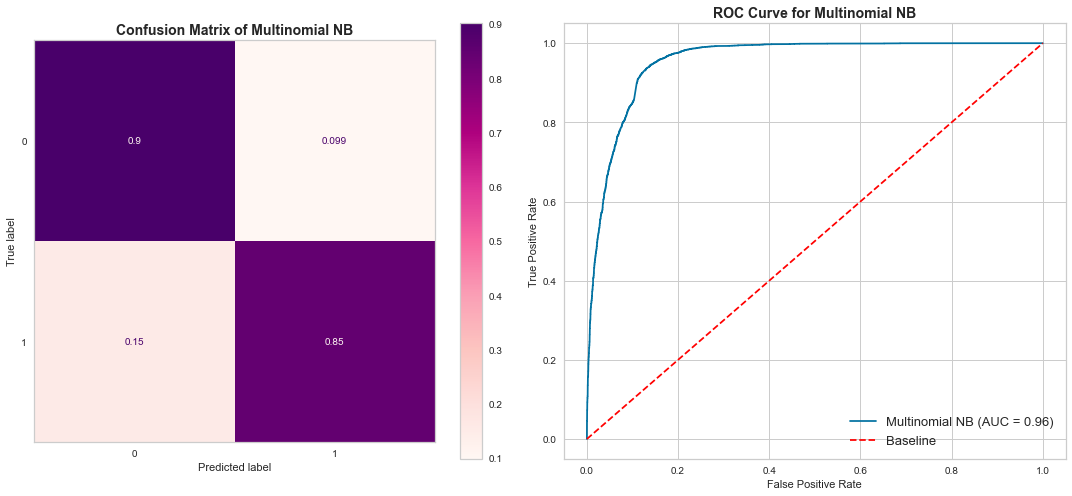

In [114]:
confusion_matrix(y_preds_nb,'Multinomial NB')
subplot_matrix_roc(gs_nb, 'Multinomial NB', 'RdPu')

Confusion Matrix for RandomForest:
True Negatives: 5730
False Positives: 153
False Negatives: 3128
True Positives: 2061


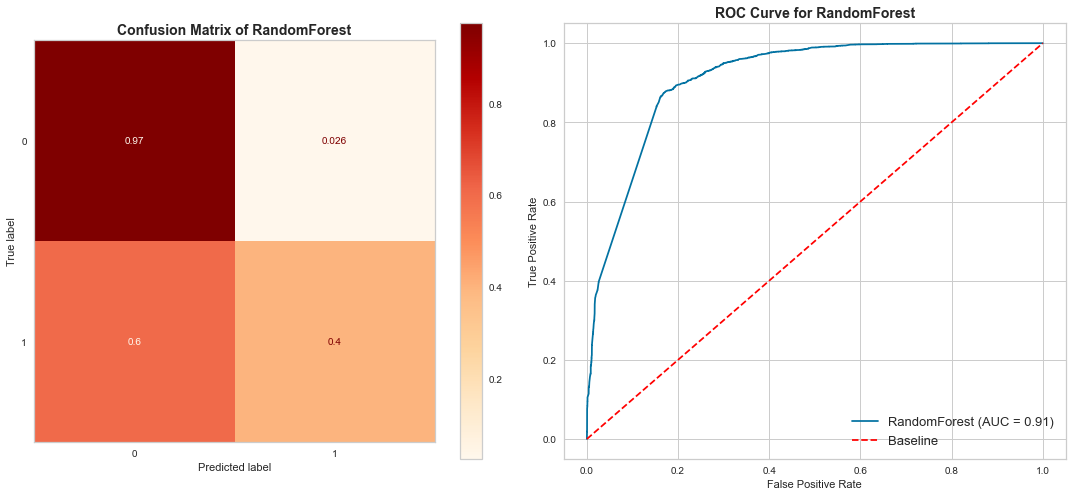

In [115]:
confusion_matrix(y_preds_rf,'RandomForest')
subplot_matrix_roc(gs_rf, 'RandomForest', 'OrRd')

Confusion Matrix for StackingClassifier with Logistic Regression:
True Negatives: 5435
False Positives: 448
False Negatives: 408
True Positives: 4781


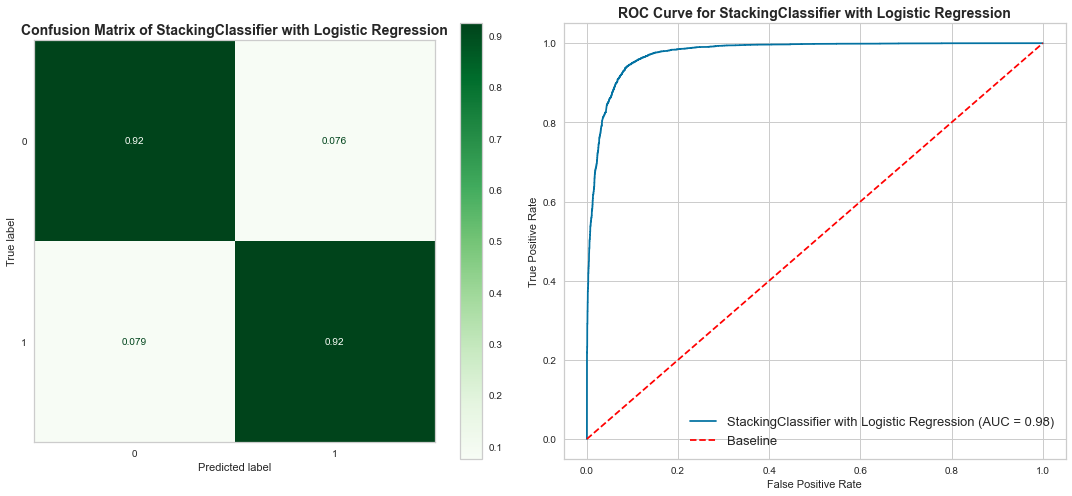

In [113]:
confusion_matrix(y_preds_stack,'StackingClassifier with Logistic Regression')
subplot_matrix_roc(stacking_classifiers, 'StackingClassifier with Logistic Regression', 'Greens')

For the `Multinomial Naive Bayes`, it has a 99% accuracy in predicting True Positives (predicted `r/Philosophy` and actually `r/Philosophy`) at 99% but in predicting True Negative (predicted `r/Science` and actually `r/Science`), it did not perform as well at 85%. This means it has a high prediction rate for predicting `r/Philosophy` but not so much for `r/Science`. From the ROC curve we also see how decent the model is with Area Under Curve (AUC) being 0.96, however it does not perform as much at lower decision threshold.

For `RandomForest`, it scored very well in predicting True Positives at 92% but failed marginally in the rest. This can be further cemented from the table of scoring metrics earlier on, we can see that its Precision score is the highest at 0.931 while the rest scored very poorly as a comparison. Similar to MNB, it has a high prediction rate for predicting `r/Philosophy`, however is not good at prediction for `r/Science`. As for the ROC curve, it is especially poor at lower threshold and is not particularly good at classifying even though the AUC is 0.91 (91% chance of distinguishing between `r/Philosophy` and `r/Science`)

From the 3 confusion matrix and ROC curve, we can see how accurate and balanced our final model is, with about 92% accuracy in predicting True Positives and True Negatives while having a low prediction in False Positives and False Negatives, as well as an AUC of 0.98 (98% chance of distinguishing between `r/Philosophy` and `r/Science`).

------------------------------------------------

## Conclusion

Going back to our problem statement in the beginning, we have successfully created an effective classification model using NLP techniques based on the commendable scores across the scoring metrics. Our final model incorporating the `TFIDF Vectorizer` and `Logistic Regression` (after using `Stacking Classifier`) delivered great results in terms of classifying posts correctly, indicating high predictive performance. Although it would not be able to 100% accurately classify submissions to their correct subreddit, it will be able to give a gauge on the majority of the submissions based on our dataset. 

### Recommendations

One limitation is that our model is able to accurately classify these submission between `r/Science` or `r/Philosophy` is because the latter is plagued with spam posts while the former barely has any. This could be a potential reason for its high success rate as a post with high spam words will be classified in `r/Philosophy` which defeats the purpose of our project. 
An improvement to this model would be to gather more data in a larger timeframe and thus having a larger pool of information. Even when we clean the datasets of bots submission and spam, there will still be sufficient data if the data was vast in the first place. 

In addition, the timespan of posts is also constrained and the data may thus be affected by certain events that do not consistently happen. For instance, our EDA showed that COVID-19 were prevalent in both subreddits. However, this was definitely not the case before the year 2020, and perhaps our model would perform very differently if given the subreddit data for a much longer time frame. 

We could also try and incorporate more semantic concepts into our model such as a measure of sentiment analysis to help add another feature to classify posts. For example using a pre-trained model from [HuggingFace](https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html) which has many sentiment analysis trained models. All of this can be accumulated to making an app to show where redditors can post their intended submissions and show users the sentiment analysis of their text (for example the submitted posts are positive/negative and subjective/objective in nature) which would be more useful for redditors and subreddit moderators.